# CALTECH101 데이터셋 분류하기
## 데이터셋 구성
# CALETECH101.zip
## accordion
### - image_0001.jpg
### - image_0002.jpg
## airplanes
### - image_0001.jpg
### - image_0002.jpg
...

In [1]:
#https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
import tensorflow as tf

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0' # Set to -1 if CPU should be used CPU = -1 , GPU = 0

gpus = tf.config.experimental.list_physical_devices('GPU')
cpus = tf.config.experimental.list_physical_devices('CPU')

if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
elif cpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        logical_cpus= tf.config.experimental.list_logical_devices('CPU')
        print(len(cpus), "Physical CPU,", len(logical_cpus), "Logical CPU")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorflow\python\framework

1 Physical CPU, 1 Logical CPU


C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\User\Anaconda3\envs\test\lib\site-packages\tensor

In [2]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.regularizers import l2
# pip install imutils
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

Using TensorFlow backend.


In [3]:
# StrideNet
class StridedNet:
	@staticmethod
	def build(width, height, depth, classes, reg, init="he_normal"):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# our first CONV layer will learn a total of 16 filters, each
		# Of which are 7x7 -- we'll then apply 2x2 strides to reduce
		# the spatial dimensions of the volume
		model.add(Conv2D(16, (7, 7), strides=(2, 2), padding="valid", kernel_initializer=init, kernel_regularizer=reg, input_shape=inputShape))

		# here we stack two CONV layers on top of each other where
		# each layerswill learn a total of 32 (3x3) filters
		model.add(Conv2D(32, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# stack two more CONV layers, keeping the size of each filter
		# as 3x3 but increasing to 64 total learned filters
		model.add(Conv2D(64, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# increase the number of filters again, this time to 128
		model.add(Conv2D(128, (3, 3), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Conv2D(128, (3, 3), strides=(2, 2), padding="same", kernel_initializer=init, kernel_regularizer=reg))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(Dropout(0.25))

		# fully-connected layer
		model.add(Flatten())
		model.add(Dense(512, kernel_initializer=init))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

In [4]:
# initialize the set of labels from the CALTECH-101 dataset we are
# going to train our network on
# 다른 카테고리들은 사용하지 않고 아래 4개의 카테고리만 사용할 것임
LABELS = set(["Faces", "Leopards", "Motorbikes", "airplanes"])

In [5]:
#imagedir = 'CALTECH101_ObjectCategories'
imagefilename = 'D:/파이썬딥러닝/PyImageSearchDeepLearning.vol1/CALTECH101_ObjectCategories.zip'
import zipfile
print("[INFO] loading images...")
#imagePaths = list(paths.list_images(imagedir))
zf = zipfile.ZipFile(imagefilename)
imagelist = zf.namelist()
data = []
labels = []

# print(imagelist) - zip안에 있는 카테고리/이미지이름.jpg로 구성됨

[INFO] loading images...


In [6]:
# zip안에 있는 카테고리/이미지이름.jpg로 구성된 list에서

for imagePath in imagelist:
    # 카테고리 이름만 추출함
	label = imagePath.split('/')[-2]

    # 위에 설정한 LABELS에 속하지 않으면 저장하지 않고 넘어감
	if label not in LABELS:
		continue

    # 해당 LABELS에 속하는 이미지들을
	imagedata = zf.read(imagePath)
    # unit8로 바꾸고, resize하여 불러옴
	image = cv2.imdecode(np.frombuffer(imagedata, np.uint8), 1)
	image = cv2.resize(image, (96, 96))

    # data에는 이미지를 담고(이미지 1개 - labels 1개)
	data.append(image)
    # label에는 label을 담음
	labels.append(label)
    
# print(data)
# print(labels)

In [7]:
# 이미지 pixels [0,1] 범위로 조정
data = np.array(data, dtype="float") / 255.0

In [8]:
# labels one-hot encoding
lb = LabelBinarizer()
labels = lb.fit_transform(labels)

In [9]:
# 전체 이미지 data를 trainX, testX로 나누고,
# 전체 Label를 trainY, testY로 나눔
# train : 0.75%, test : 0.25%
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, stratify=labels, random_state=42)
print(len(trainX))
print(len(testX))
print(len(trainY))
print(len(testY))

1674
559
1674
559


In [10]:
# construct the training image generator for data augmentation
# 데이터 증강기법
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

In [11]:
# epoch, optimization 등 조정 후 compile
maxepoch = 50
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = Adam(lr=1e-4, decay=1e-4 / maxepoch)
model = StridedNet.build(width=96, height=96, depth=3, classes=len(lb.classes_), reg=l2(0.0005))
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 45, 45, 16)        2368      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 32)        4640      
_________________________________________________________________
activation_1 (Activation)    (None, 45, 45, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 45, 45, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 23, 23, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 32)       

In [14]:
# 모델 학습
print("[INFO] training network for {} epochs...".format(maxepoch))
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=64), validation_data=(testX, testY), steps_per_epoch=len(trainX) // 64, epochs=maxepoch, verbose=1)
#batch_size: 32->10 for small GPU memory

[INFO] training network for 50 epochs...
Epoch 1/50
26/26 [==============================] - 15s 561ms/step - loss: 1.3756 - accuracy: 0.7335 - val_loss: 1.6085 - val_accuracy: 0.5957
Epoch 2/50
26/26 [==============================] - 14s 527ms/step - loss: 1.2487 - accuracy: 0.7602 - val_loss: 1.3942 - val_accuracy: 0.6583
Epoch 3/50
26/26 [==============================] - 14s 541ms/step - loss: 1.1408 - accuracy: 0.7909 - val_loss: 1.3626 - val_accuracy: 0.7335
Epoch 4/50
26/26 [==============================] - 14s 526ms/step - loss: 1.0545 - accuracy: 0.8186 - val_loss: 1.3767 - val_accuracy: 0.7585
Epoch 5/50
26/26 [==============================] - 13s 510ms/step - loss: 0.9895 - accuracy: 0.8374 - val_loss: 1.3117 - val_accuracy: 0.7835
Epoch 6/50
26/26 [==============================] - 14s 540ms/step - loss: 0.9604 - accuracy: 0.8504 - val_loss: 1.0933 - val_accuracy: 0.8032
Epoch 7/50
26/26 [==============================] - 13s 509ms/step - loss: 1.0092 - accuracy: 0.8593 

In [15]:
# 모델 평가(test 데이터에 대하여)
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=64)
# precision : 예측 결과 중 참
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html#sklearn.metrics.precision_recall_fscore_support
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...
              precision    recall  f1-score   support

       Faces       0.94      1.00      0.97       109
    Leopards       1.00      0.74      0.85        50
  Motorbikes       0.98      0.99      0.98       200
   airplanes       0.97      0.98      0.98       200

    accuracy                           0.97       559
   macro avg       0.97      0.93      0.94       559
weighted avg       0.97      0.97      0.97       559



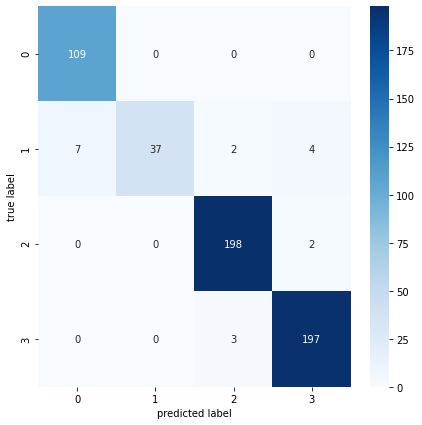

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 혼동 행렬을 만듭니다.
plt.figure(figsize = (7, 7))
# testX와 testY가 일치한 경우(0,1,2,3 => Label 0, 1, 2, 3)
cm = confusion_matrix(testY.argmax(axis=1), predictions.argmax(axis=1))
# y_test와 results의 numpy 행렬에서 최고 차수(-1)를 기준으로 비교하여 최고값을 선정.
sns.heatmap(cm, annot = True, fmt = 'd',cmap = 'Blues')
# sklearn의 데이터를 이용하여 heatmap을 시각화해주는 seaborn의 패키지
# 
plt.xlabel('predicted label')
plt.ylabel('true label')
plt.show()

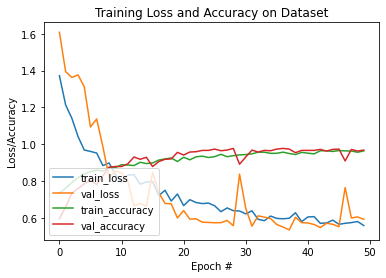

In [17]:
# plot the training loss and accuracy
import matplotlib
%matplotlib inline
plt.figure()
plt.plot(np.arange(0, maxepoch), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, maxepoch), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, maxepoch), H.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, maxepoch), H.history["val_accuracy"], label="val_accuracy")

plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()